In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('../Dataset/heart.csv')
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.00,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.00,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.00,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.50,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.00,Up,0


In [3]:
col = list(data.columns)
categorical_features = []
numerical_features = []
for i in col:
    if len(data[i].unique()) > 6:
        numerical_features.append(i)
    else:
        categorical_features.append(i)

print('Categorical Features :',*categorical_features)
print('Numerical Features :',*numerical_features)

Categorical Features : Sex ChestPainType FastingBS RestingECG ExerciseAngina ST_Slope HeartDisease
Numerical Features : Age RestingBP Cholesterol MaxHR Oldpeak


In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df1 = data.copy(deep = True)

df1['Sex'] = le.fit_transform(df1['Sex'])
df1['ChestPainType'] = le.fit_transform(df1['ChestPainType'])
df1['RestingECG'] = le.fit_transform(df1['RestingECG'])
df1['ExerciseAngina'] = le.fit_transform(df1['ExerciseAngina'])
df1['ST_Slope'] = le.fit_transform(df1['ST_Slope'])

In [5]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
mms = MinMaxScaler() # Normalization
ss = StandardScaler() # Standardization

df1['Oldpeak'] = mms.fit_transform(df1[['Oldpeak']])
df1['Age'] = ss.fit_transform(df1[['Age']])
df1['RestingBP'] = ss.fit_transform(df1[['RestingBP']])
df1['Cholesterol'] = ss.fit_transform(df1[['Cholesterol']])
df1['MaxHR'] = ss.fit_transform(df1[['MaxHR']])
df1.head()


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,-1.43,1,1,0.41,0.83,0,1,1.38,0,0.30,2,0
1,-0.48,0,2,1.49,-0.17,0,1,0.75,0,0.41,1,1
2,-1.75,1,1,-0.13,0.77,0,2,-1.53,0,0.30,2,0
3,-0.58,0,0,0.30,0.14,0,1,-1.13,1,0.47,1,1
4,0.05,1,2,0.95,-0.03,0,1,-0.58,0,0.30,2,0


In [6]:
plt.figure(figsize = (20,5))
sns.heatmap(df1.corr(),cmap = colors,annot = True);

NameError: name 'colors' is not defined

<Figure size 1440x360 with 0 Axes>

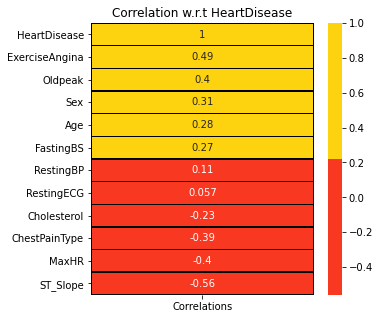

In [41]:
corr = df1.corrwith(df1['HeartDisease']).sort_values(ascending = False).to_frame()
corr.columns = ['Correlations']
plt.subplots(figsize = (5,5))
sns.heatmap(corr,annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black');
plt.title('Correlation w.r.t HeartDisease');

In [42]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

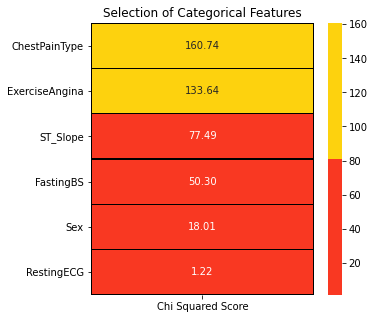

In [43]:
features = df1.loc[:,categorical_features[:-1]]
target = df1.loc[:,categorical_features[-1]]

best_features = SelectKBest(score_func = chi2,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['Chi Squared Score']) 

plt.subplots(figsize = (5,5))
sns.heatmap(featureScores.sort_values(ascending = False,by = 'Chi Squared Score'),annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Categorical Features');

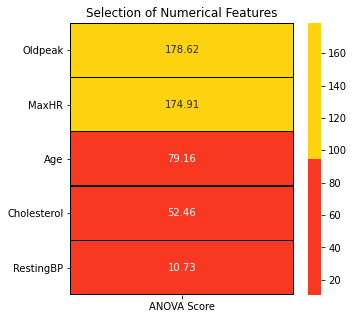

In [44]:
from sklearn.feature_selection import f_classif

features = df1.loc[:,numerical_features]
target = df1.loc[:,categorical_features[-1]]

best_features = SelectKBest(score_func = f_classif,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['ANOVA Score']) 

plt.subplots(figsize = (5,5))
sns.heatmap(featureScores.sort_values(ascending = False,by = 'ANOVA Score'),annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Numerical Features');

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import precision_recall_curve

In [46]:
features = df1[df1.columns.drop(['HeartDisease','RestingBP','RestingECG'])].values
target = df1['HeartDisease'].values
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.20, random_state = 2)

In [47]:
def model(classifier):
    
    classifier.fit(x_train,y_train)
    prediction = classifier.predict(x_test)
    cv = RepeatedStratifiedKFold(n_splits = 10,n_repeats = 3,random_state = 1)
    print("Accuracy : ",'{0:.2%}'.format(accuracy_score(y_test,prediction)))
    print("Cross Validation Score : ",'{0:.2%}'.format(cross_val_score(classifier,x_train,y_train,cv = cv,scoring = 'roc_auc').mean()))
    print("ROC_AUC Score : ",'{0:.2%}'.format(roc_auc_score(y_test,prediction)))
    plot_roc_curve(classifier, x_test,y_test)
    plt.title('ROC_AUC_Plot')
    plt.show()

def model_evaluation(classifier):
    
    # Confusion Matrix
    cm = confusion_matrix(y_test,classifier.predict(x_test))
    names = ['True Neg','False Pos','False Neg','True Pos']
    counts = [value for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm,annot = labels,cmap = colors,fmt ='')
    
    # Classification Report
    print(classification_report(y_test,classifier.predict(x_test)))

In [48]:
from sklearn.linear_model import LogisticRegression

In [49]:
classifier_lr = LogisticRegression(random_state = 0,C=10,penalty= 'l2') 

Accuracy :  87.50%
Cross Validation Score :  91.12%
ROC_AUC Score :  87.43%


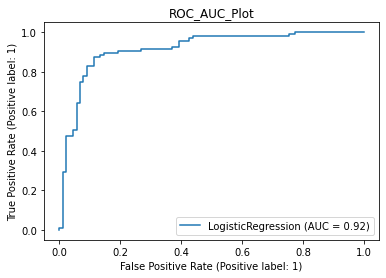

In [50]:
model(classifier_lr)

              precision    recall  f1-score   support

           0       0.88      0.85      0.87        89
           1       0.87      0.89      0.88        95

    accuracy                           0.88       184
   macro avg       0.88      0.87      0.87       184
weighted avg       0.88      0.88      0.87       184



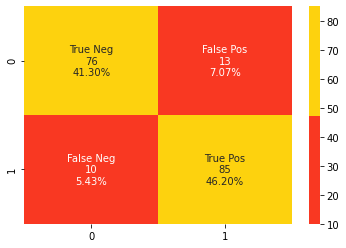

In [51]:
model_evaluation(classifier_lr)

In [52]:
from sklearn.svm import SVC

In [53]:
classifier_svc = SVC(kernel = 'linear',C = 0.1)

Accuracy :  87.50%
Cross Validation Score :  90.53%
ROC_AUC Score :  87.43%


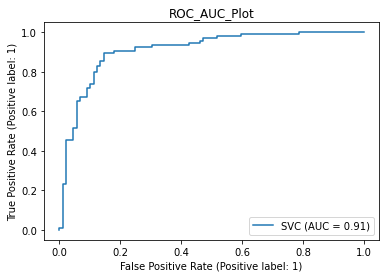

In [54]:
model(classifier_svc)

              precision    recall  f1-score   support

           0       0.88      0.85      0.87        89
           1       0.87      0.89      0.88        95

    accuracy                           0.88       184
   macro avg       0.88      0.87      0.87       184
weighted avg       0.88      0.88      0.87       184



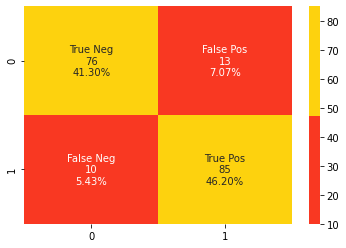

In [55]:
model_evaluation(classifier_svc)

In [56]:
from sklearn.tree import DecisionTreeClassifier

In [89]:
classifier_dt = DecisionTreeClassifier(random_state = 1000,max_depth = 4,min_samples_leaf = 3)

Accuracy :  83.70%
Cross Validation Score :  89.38%
ROC_AUC Score :  83.50%


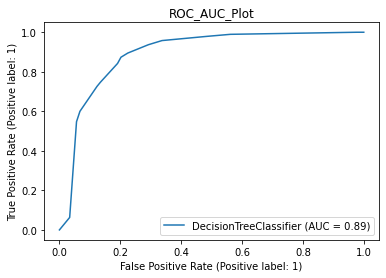

In [90]:
model(classifier_dt)

              precision    recall  f1-score   support

           0       0.87      0.78      0.82        89
           1       0.81      0.89      0.85        95

    accuracy                           0.84       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.84      0.84      0.84       184



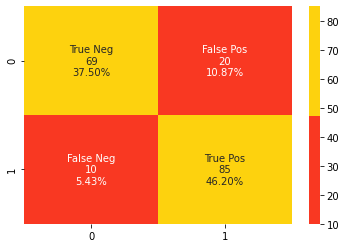

In [91]:
model_evaluation(classifier_dt)

In [61]:
from sklearn.ensemble import RandomForestClassifier

In [62]:
classifier_rf = RandomForestClassifier(max_depth = 4,random_state = 0)

Accuracy :  84.24%
Cross Validation Score :  92.91%
ROC_AUC Score :  84.06%


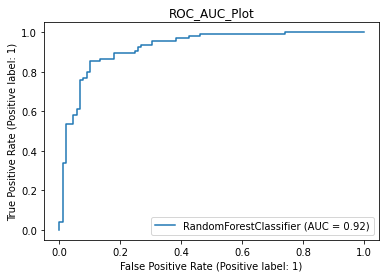

In [63]:
model(classifier_rf)

              precision    recall  f1-score   support

           0       0.88      0.79      0.83        89
           1       0.82      0.89      0.85        95

    accuracy                           0.84       184
   macro avg       0.85      0.84      0.84       184
weighted avg       0.85      0.84      0.84       184



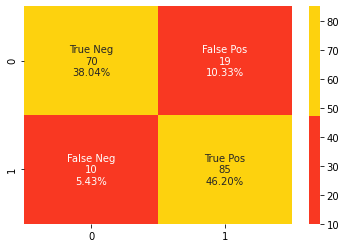

In [64]:
model_evaluation(classifier_rf)

In [65]:
from sklearn.neighbors import KNeighborsClassifier

In [66]:
classifier_knn = KNeighborsClassifier(leaf_size = 1, n_neighbors = 3,p = 1)

Accuracy :  81.52%
Cross Validation Score :  89.34%
ROC_AUC Score :  81.36%


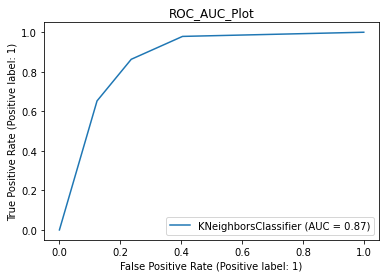

In [67]:
model(classifier_knn)

              precision    recall  f1-score   support

           0       0.84      0.76      0.80        89
           1       0.80      0.86      0.83        95

    accuracy                           0.82       184
   macro avg       0.82      0.81      0.81       184
weighted avg       0.82      0.82      0.81       184



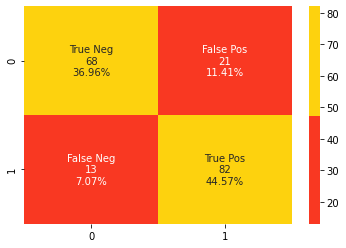

In [68]:
model_evaluation(classifier_knn)